# Visium HD tutorial

We can run Sopa on Visium HD, as the 2 micron bins are subcellular. You can follow the ["normal" API tutorial](../api_usage), or continue below to get exemples more specific to Visium HD data.

For this tutorial, we use the [mouse small intestine public dataset](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-mouse-intestine) from 10X Genomics.

In [1]:
import sopa
import spatialdata

/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Reading the data

In [3]:
sdata_full = sopa.io.visium_hd("data/visium_hd/Visium_HD_Mouse_Small_Intestine")
sdata_full

/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_full_image': DataTree[cyx] (3, 21943, 23618), (3, 10971, 11809), (3, 5485, 5904), (3, 2742, 2952), (3, 1371, 1476)
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (5479660, 1) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (351817, 1) (2D shapes)
│     └── 'Visium_HD_Mouse_Small_Intestine_square_016um': GeoDataFrame shape: (91033, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (5479660, 19059)
      ├── 'square_008um': AnnData (351817, 19059)
      └── 'square_016um': AnnData (91033, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        Visium_HD_Mouse_Small_Intestine_hires_image (Images), Visium_HD_Mouse_Small_Intestine

For simplicity, we crop the dataset (so that the tutorial runs faster).

In [4]:
sdata = sdata_full.query.bounding_box(
    axes=["y", "x"], min_coordinate=[10_000, 10_000], max_coordinate=[15_000, 15_000], target_coordinate_system="global"
)

/Users/quentinblampey/miniforge3/envs/spatial-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Then, we save it on-disk:

In [ ]:
sdata.write("sub_visium_hd.zarr") # save it

sdata = spatialdata.read_zarr("sub_visium_hd.zarr") # open-it back

## Usual pipeline

Now, we run Sopa as usual. Although, since we don't have transcripts, we can't run Baysor. Therefore, we will run [Stardist](https://github.com/stardist/stardist) on the H&E image.

First, we create the patches for the cell segmentation.

In [5]:
sopa.make_image_patches(sdata)

/Users/quentinblampey/dev/spatialdata/src/spatialdata/_core/_elements.py:104: UserWarning: Key `image_patches` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
[INFO] (sopa.patches._patches) 9 patches were added to sdata['image_patches']


For faster segmentation, we recommend using the `"dask"` parallelization backend:

In [9]:
sopa.settings.parallelization_backend = "dask" # optional
sopa.settings.dask_client_kwargs = {"n_workers": 4} # optional

Now we can run stardist on the H&E image. Here, we update `prob_thresh` and `nms_thresh` to get more cells.

In [ ]:
sopa.segmentation.stardist(sdata, prob_thresh=0.3, nms_thresh=0.6, min_area=30)

## Aggregation

Now, we need to run [`sopa.aggregate`](../../api/aggregation/#sopa.aggregate) to aggregate the bins into the cells. For each cell, Sopa will sum the transcript counts of all 2-microns-bins touching or included within the cell.

> There is an argument `bins_key`, but by default Sopa will understand that it's Visium HD data and that it should use the 2-microns bins. Also, on the example below, we only aggregate the bins, not the H&E channels.

In [7]:
sopa.aggregate(sdata, aggregate_channels=False)

aligned_df.py (68): Transforming to str index.
anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
_elements.py (104): Key `stardist_boundaries` already exists. Overwriting it in-memory.
_elements.py (124): Key `table` already exists. Overwriting it in-memory.


## Single-cell table

Now, we have an AnnData object with the gene expression **per cell**.

In [8]:
adata = sdata["table"]
adata

AnnData object with n_obs × n_vars = 13926 × 19059
    obs: 'region', 'slide', 'cell_id', 'area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'spatial'

For instance, we can now use Scanpy to plot gene expression.

In [9]:
import scanpy as sc

In [10]:
# basic preprocessing
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_counts=20)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1758): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


We can then use `sc.pl.spatial` to show the gene expression per cells. Note that, here, we show **cells**, not bins.

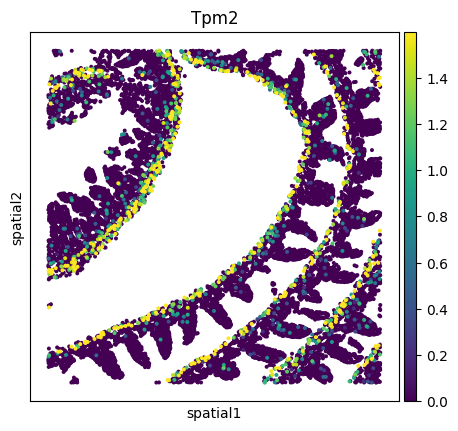

In [11]:
sc.pl.spatial(adata, color="Tpm2", spot_size=60, vmax="p98")

## Bins visualization

The 2-micron bins are arranged in a grid, so they can be visualized as an image of `G` channels, where `G` is the number of genes.

Creating the image would be massive, so we need to create it lazily. This can be done with `spatialdata.rasterize_bins`.

In [12]:
sdata["square_002um"].X = sdata["square_002um"].X.tocsc() # optimisation with the csc format

lazy_bins_image = spatialdata.rasterize_bins(
    sdata,
    bins="Visium_HD_Mouse_Small_Intestine_square_002um", # key of the bins shapes
    table_name="square_002um", # key of the table with the bins gene expression
    row_key="array_row",
    col_key="array_col",
)

Note that `lazy_bins_image` is an image of size `(19059, 690, 690)`, that is `G=19059` genes, and `690x690` bins. This would correspond to a 33.80GB image in memory, if it wasn't lazy.

In [ ]:
lazy_bins_image

We can save this image in the `sdata` object.

In [14]:
sdata["gene_expression_2_um"] = lazy_bins_image

Then, we can visualize this image with Napari. When showing a gene, it will compute the corresponding layer of the lazy image, and it will be displayed in milliseconds, i.e. looking instantaneous.

In [15]:
from napari_spatialdata import Interactive

Interactive(sdata)

You'll be able to display cells and the bins expression. It should look like that:

<p align="center">
  <img src="../../assets/napari_visium_hd.png" alt="napari_visium_hd" width="600px"/>
</p>

## Xenium Explorer
Although the Xenium Explorer can be used (as below), it will not display the bins. If you want to see the bins, use `Napari` as detailed above.

In [16]:
sopa.io.explorer.write("mouse_intestine.explorer", sdata)

[INFO] (sopa.io.explorer.table) Writing table with 11708 columns
[INFO] (sopa.io.explorer.table) Writing 2 cell categories: region, slide
[INFO] (sopa.io.explorer.shapes) Writing 13347 cell polygons
[INFO] (sopa.io.explorer.images) Writing multiscale image with procedure=semi-lazy (load in memory when possible)
[INFO] (sopa.io.explorer.images)    (Loading image of shape (3, 5000, 5000)) in memory
[INFO] (sopa.io.explorer.images)    > Image of shape (3, 5000, 5000)
[INFO] (sopa.io.explorer.images)    > Image of shape (3, 2500, 2500)
[INFO] (sopa.io.explorer.images)    > Image of shape (3, 1250, 1250)
[INFO] (sopa.io.explorer.images)    > Image of shape (3, 625, 625)
[INFO] (sopa.io.explorer.images)    > Image of shape (3, 312, 312)
[INFO] (sopa.io.explorer.images)    > Image of shape (3, 156, 156)
[INFO] (sopa.io.explorer.converter) Saved files in the following directory: mouse_intestine.explorer
[INFO] (sopa.io.explorer.converter) You can open the experiment with 'open mouse_intestine.